In [63]:
import pandas as pd
import numpy as np
from numpy.random import shuffle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
pd.set_option('display.max_rows',30)

# Regression and Classification with Decision Tree and Random Forest.
Includes: train_test_split, cross_val_score, StratifiedKFold, confusion_matrix, roc_curve, roc_auc_score and SelectKBest

# 1) Regression

We want to predict the value of real state in Buenos Aires, Argentina.

## 1.1) Decision Tree Regressor

In [64]:
filename = 'Precios_Departamentos_2016.csv'
df = pd.read_csv(filename)
df.head()

,M2,AMBIENTES,ANTIGUEDAD,BAÑOS,LATITUD,LONGITUD,COMUNA,DOLARES
0,81,3,4,1,-34.581078,-58.449433,COMUNA 13,225000
1,69,3,20,1,-34.623129,-58.439338,COMUNA 06,140000
2,75,3,20,1,-34.604972,-58.421278,COMUNA 05,154000
3,42,2,40,1,-34.604725,-58.399524,COMUNA 03,75000
4,90,3,1,1,-34.623390,-58.504401,COMUNA 10,149900


In [65]:
# Converts 'Dolares' column to logarihmic in order to improve prediction
df['log10_DOLARES'] = np.log10(df['DOLARES']) 
df.head()

,M2,AMBIENTES,ANTIGUEDAD,BAÑOS,LATITUD,LONGITUD,COMUNA,DOLARES,log10_DOLARES
0,81,3,4,1,-34.581078,-58.449433,COMUNA 13,225000,5.352183
1,69,3,20,1,-34.623129,-58.439338,COMUNA 06,140000,5.146128
2,75,3,20,1,-34.604972,-58.421278,COMUNA 05,154000,5.187521
3,42,2,40,1,-34.604725,-58.399524,COMUNA 03,75000,4.875061
4,90,3,1,1,-34.623390,-58.504401,COMUNA 10,149900,5.175802


In [66]:
features = ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'LATITUD', 'LONGITUD'] 
target = 'log10_DOLARES'

X = df[features].to_numpy()
y = df[target].to_numpy()

print(f'Size feature matrix: {X.shape}')
print(f'Size target vector: {y.shape}')
print(f'Vector to predict: {y}')

Size feature matrix: (2232, 6)
Size target vector: (2232,)
Vector to predict: [5.35218252 5.14612804 5.18752072 ... 5.71600334 5.12057393 5.25285303]


In [67]:
# Trains the DecisionTreeRegressor model with train/split and random seed value
random_seed = 1453

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y, test_size = 0.10, random_state = random_seed)

print(f'Size train matrix: {X_train_r.shape}')
print(f'Size test matrix: {X_test_r.shape}')

dtr = DecisionTreeRegressor(max_depth = 3, random_state = random_seed)
dtr.fit(X_train_r, y_train_r)

score_in_train = dtr.score(X_train_r, y_train_r)
score_in_test = dtr.score(X_test_r, y_test_r)

print(f'Train score: {score_in_train}')
print(f'Test score: {score_in_test}')

Size train matrix: (2008, 6)
Size test matrix: (224, 6)
Train score: 0.7803378153784164
Test score: 0.8091233721971078


With the fix max_depth = 3, the tree shows us that m² are the main feature selection at the beginning of the split. Latitud join it later.

[Text(0.5, 0.875, 'M2 <= 79.5\nsquared_error = 0.081\nsamples = 2008\nvalue = 5.202'),
 Text(0.25, 0.625, 'M2 <= 44.5\nsquared_error = 0.03\nsamples = 1330\nvalue = 5.053'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'M2 <= 34.5\nsquared_error = 0.014\nsamples = 536\nvalue = 4.923'),
 Text(0.0625, 0.125, 'squared_error = 0.008\nsamples = 189\nvalue = 4.849'),
 Text(0.1875, 0.125, 'squared_error = 0.012\nsamples = 347\nvalue = 4.963'),
 Text(0.375, 0.375, 'LATITUD <= -34.604\nsquared_error = 0.021\nsamples = 794\nvalue = 5.141'),
 Text(0.3125, 0.125, 'squared_error = 0.016\nsamples = 280\nvalue = 5.061'),
 Text(0.4375, 0.125, 'squared_error = 0.018\nsamples = 514\nvalue = 5.185'),
 Text(0.75, 0.625, 'M2 <= 116.5\nsquared_error = 0.054\nsamples = 678\nvalue = 5.494'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'LATITUD <= -34.596\nsquared_error = 0.02\nsamples = 343\nvalue = 5.34'),
 Text(0.5625, 0.125, 'squared_error = 0.019\nsamples = 137\nvalue = 5.272'),
 Text(0.6875, 

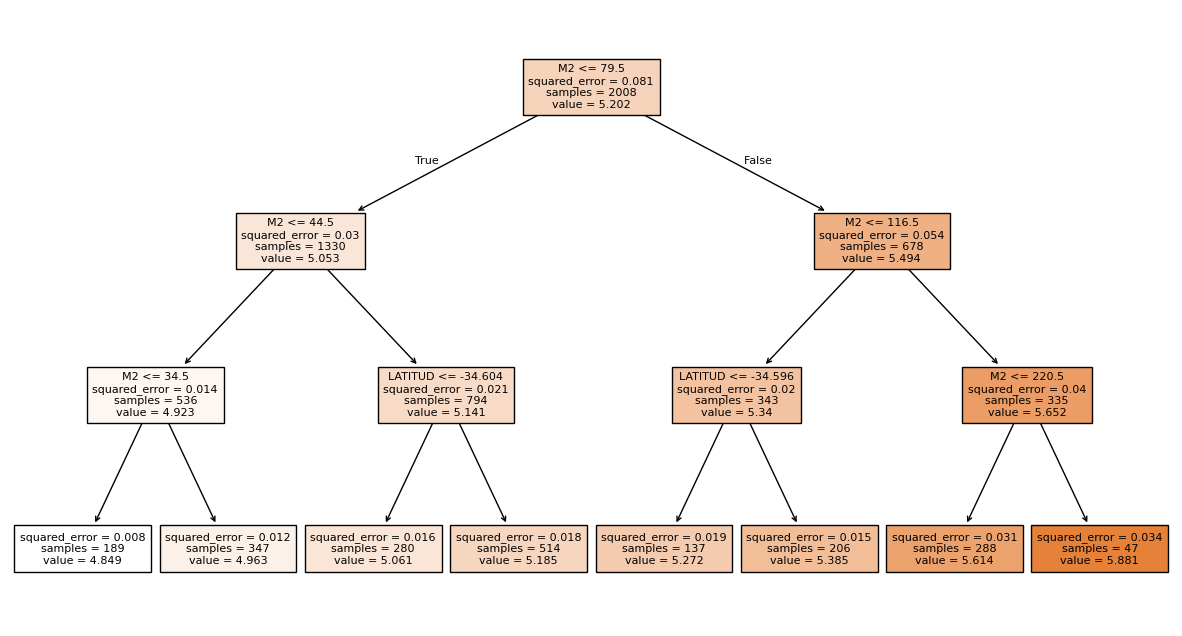

In [68]:
# Explores the tree model
fig, ax = plt.subplots(figsize = (15, 8))
plot_tree(dtr, feature_names=features, fontsize = 8, filled = True, ax = ax)

### Feature engineering
Let's iterate over some hyperparameters like max_depth, min_samples_split and min_samples_leaf.

In [69]:
# Trains and shows various scores with the set parameters
def scores_train_test_cv (X_d, y_d, maxdepth, minsamplessplit, minsamplesleaf, random_seed, C):
  dtr = DecisionTreeRegressor(max_depth = maxdepth, ccp_alpha=C, min_samples_split= minsamplessplit, min_samples_leaf= minsamplesleaf, random_state = random_seed) 
  X_train, X_test, y_train, y_test = train_test_split(X_d, y_d, test_size = 0.10, random_state = random_seed)
  dtr.fit(X_train, y_train)
  score_in_train = dtr.score(X_train, y_train)
  score_in_test = dtr.score(X_test, y_test)

  scores_cv = cross_val_score(dtr, X_d, y_d, cv = 5)

  y_pred = dtr.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mse ** 0.5

  return [round(score_in_train, 4), round(score_in_test, 4), round(rmse, 4), round(scores_cv.mean(), 4)]

In [70]:
# Finds max cv mean score
def max_in_cv (df_var, name):
  index_max = df_var.sort_values(by='cv mean score', ascending=False).index[0]
  df_var['max cv'] = ''
  df_var.loc[index_max, 'max cv'] = '*'
  blankIndex=[''] * len(df_var)
  df_var.index=blankIndex
  return df_var[[name, 'train score',	'test score', 'RMSE', 'cv mean score',	'max cv', ]]

In [71]:
# Iterates over max_depth. When the tree is too deep, the model tends to overfitt like is shown on the 'Score train' values.
df_score = pd.DataFrame(data={'max_depth':[], 'train score':[], 'test score':[], 'RMSE':[], 'cv mean score':[]})
for it in range(1,20):
  list_var = [it]
  list_var.extend(scores_train_test_cv(X, y, it, 2, 1, random_seed, 0.0))
  df_score.loc[len(df_score)] = list_var

max_in_cv (df_score,'max_depth')

,max_depth,train score,test score,RMSE,cv mean score,max cv
,1.0,0.5346,0.4968,0.2036,0.5169,
,2.0,0.7293,0.7344,0.1479,0.7094,
,3.0,0.7803,0.8091,0.1254,0.7660,
,4.0,0.8230,0.8398,0.1148,0.8100,
,5.0,0.8586,0.8398,0.1149,0.8289,
,6.0,0.8969,0.8659,0.1051,0.8351,
,7.0,0.9225,0.8833,0.0980,0.8412,
,8.0,0.9512,0.7806,0.1344,0.8487,*
,9.0,0.9671,0.7761,0.1358,0.8460,
,10.0,0.9785,0.7784,0.1351,0.8466,


In [72]:
# Iterates over min_samples_split
df_score = pd.DataFrame(data={'min_samples_split':[], 'train score':[], 'test score':[], 'RMSE':[], 'cv mean score':[]})
for it in range(2,20):
  list_var = [it]
  list_var.extend(scores_train_test_cv(X, y, None, it, 1, random_seed, 0.0))
  df_score.loc[len(df_score)] = list_var

max_in_cv (df_score, 'min_samples_split')

,min_samples_split,train score,test score,RMSE,cv mean score,max cv
,2.0,0.9999,0.7883,0.1320,0.8331,
,3.0,0.9976,0.7997,0.1284,0.8336,
,4.0,0.9949,0.7924,0.1307,0.8411,
,5.0,0.9920,0.7975,0.1291,0.8387,
,6.0,0.9884,0.7863,0.1326,0.8425,
,7.0,0.9849,0.7910,0.1312,0.8405,
,8.0,0.9813,0.7870,0.1324,0.8434,
,9.0,0.9784,0.7896,0.1316,0.8491,
,10.0,0.9751,0.7926,0.1307,0.8474,
,11.0,0.9715,0.7935,0.1304,0.8473,


Iteration over min_samples_leaf.

In [73]:
df_score = pd.DataFrame(data={'min_samples_leaf':[], 'train score':[], 'test score':[], 'RMSE':[], 'cv mean score':[]})
for it in range(2,20):
  list_var = [it]
  list_var.extend(scores_train_test_cv(X, y, None, 2, it, random_seed, 0.0))
  df_score.loc[len(df_score)] = list_var

max_in_cv (df_score, 'min_samples_leaf')

,min_samples_leaf,train score,test score,RMSE,cv mean score,max cv
,2.0,0.9818,0.8663,0.1049,0.8443,
,3.0,0.9683,0.8820,0.0986,0.8440,
,4.0,0.9584,0.8869,0.0965,0.8494,
,5.0,0.9495,0.8998,0.0908,0.8537,
,6.0,0.9415,0.9010,0.0903,0.8541,
,7.0,0.9344,0.8967,0.0922,0.8565,*
,8.0,0.9290,0.8978,0.0917,0.8541,
,9.0,0.9240,0.9026,0.0896,0.8542,
,10.0,0.9200,0.8941,0.0934,0.8548,
,11.0,0.9148,0.8951,0.0929,0.8560,


Iteration over alpha.

In [74]:
df_score = pd.DataFrame(data={'ccp_alpha':[], 'train score':[], 'test score':[], 'RMSE':[], 'cv mean score':[]})
for it in np.logspace(-10, 0, 11):
  list_var = [it]
  list_var.extend(scores_train_test_cv(X, y, None, 2, 1, random_seed, it))
  df_score.loc[len(df_score)] = list_var

max_in_cv (df_score, 'ccp_alpha')

,ccp_alpha,train score,test score,RMSE,cv mean score,max cv
,1.000000e-10,0.9999,0.7883,0.1320,0.8331,
,1.000000e-09,0.9999,0.7883,0.1320,0.8331,
,1.000000e-08,0.9999,0.7884,0.1320,0.8330,
,1.000000e-07,0.9998,0.7879,0.1322,0.8335,
,1.000000e-06,0.9979,0.7882,0.1321,0.8334,
,1.000000e-05,0.9755,0.7852,0.1330,0.8438,*
,1.000000e-04,0.8966,0.7663,0.1387,0.8401,
,1.000000e-03,0.7640,0.7872,0.1324,0.7561,
,1.000000e-02,0.5346,0.4968,0.2036,0.5777,
,1.000000e-01,0.0000,-0.0162,0.2893,-0.0015,


In [75]:
# RMSE score with the best parameters obtained through the iterations
v_train, v_test, v_cv, v_rmse = scores_train_test_cv(X, y, 8, 14, 7, random_seed, 10**-5)
print(f'RMSE score : {round(v_rmse, 4)}')

RMSE score : 0.8558


In [76]:
param_grid = {
    'ccp_alpha': np.logspace(-10, 0, 11),
    'max_depth': range(1, 20, 1),
    'min_samples_split': range(2, 20, 1),
    'min_samples_leaf': range(1, 20, 1),
}

dtree_reg = DecisionTreeRegressor(random_state=random_seed) # Initialize a decision tree regressor
grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train_r, y_train_r)
best_dtree_reg = grid_search.best_estimator_ # Get the best estimator from the grid search
y_pred = best_dtree_reg.predict(X_test_r)
mse = mean_squared_error(y_test_r, y_pred)
rmse = mse ** 0.5
best_params = grid_search.best_params_
print(best_params)
print(f"Test RMSE score: {rmse}\n")

Fitting 5 folds for each of 71478 candidates, totalling 357390 fits
{'ccp_alpha': np.float64(1e-05), 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 12}
Test RMSE score: 0.13169524667184473



Let's try with the grid search best parameters.

In [77]:
v_train, v_test, v_rmse, v_cv = scores_train_test_cv(X, y, 14, 12, 1, random_seed, 10**-5)
print(f'RMSE Score: {v_rmse}')

RMSE Score: 0.1317


## 1.2) Random Forest Regressor

In [78]:
# Trains RandomForestRegressor with various n_estimators values
v_train, v_test, v_rmse, v_cv = scores_train_test_cv(X, y, 14, 12, 1, random_seed, 10**-5)
print(f'Test score Decision Tree: {v_test}')

for estim in [100, 500, 1000]:
    rfr = RandomForestRegressor(n_estimators=estim, random_state = random_seed)
    rfr.fit(X_train_r, y_train_r)
    score_in_test = rfr.score(X_test_r, y_test_r)
    print(f'Test score Random Forest with {estim} estimator: {score_in_test}')

Test score Decision Tree: 0.7894
Test score Random Forest with 100 estimator: 0.9296608480758846
Test score Random Forest with 500 estimator: 0.9282997591476627
Test score Random Forest with 1000 estimator: 0.9277432438610788


Exploration of the feature importances of the Random Forest model.

In [79]:
feature_importance = rfr.feature_importances_        

pd.DataFrame(data={'feature':features, 'importance':feature_importance}).sort_values(by='importance', ascending=False).reset_index(drop=True)

,feature,importance
0,M2,0.811218
1,LATITUD,0.080025
2,LONGITUD,0.051461
3,ANTIGUEDAD,0.038678
4,AMBIENTES,0.010917
5,BAÑOS,0.007701


In [80]:
predicted_log_value = rfr.predict(X_test_r[0].reshape(1, -1))
print(f'Predicted value = $ {10**predicted_log_value.item():.2f}')
print(f'Real value = $ {10**y_test_r[0]:.2f}')
pd.DataFrame(data={'feature':features, '-':X_test_r[0]})

Predicted value = $ 1163143.27
Real value = $ 1750000.00


,feature,-
0,M2,372.000000
1,AMBIENTES,6.000000
2,ANTIGUEDAD,30.000000
3,BAÑOS,4.000000
4,LATITUD,-34.581340
5,LONGITUD,-58.403788


# 2) Classification
Let's classify which areas are the houses from regarding the features given.

## 2.1) Decision Tree Classifier

In [81]:
df = pd.read_csv(filename)                    
df['log10_DOLARES'] = np.log10(df['DOLARES'])
print(f'DF shape: {df.shape}')
df.head()

DF shape: (2232, 9)


,M2,AMBIENTES,ANTIGUEDAD,BAÑOS,LATITUD,LONGITUD,COMUNA,DOLARES,log10_DOLARES
0,81,3,4,1,-34.581078,-58.449433,COMUNA 13,225000,5.352183
1,69,3,20,1,-34.623129,-58.439338,COMUNA 06,140000,5.146128
2,75,3,20,1,-34.604972,-58.421278,COMUNA 05,154000,5.187521
3,42,2,40,1,-34.604725,-58.399524,COMUNA 03,75000,4.875061
4,90,3,1,1,-34.623390,-58.504401,COMUNA 10,149900,5.175802


In [82]:
# Creates a new 'ZONA' column for target

zonas = {'COMUNA 01': 'B', 'COMUNA 02': 'A', 'COMUNA 03': 'B',    # Relabel the areas
         'COMUNA 04': 'C', 'COMUNA 05': 'E', 'COMUNA 06': 'E',
         'COMUNA 07': 'E', 'COMUNA 08': 'C', 'COMUNA 09': 'D',
         'COMUNA 10': 'D', 'COMUNA 11': 'D', 'COMUNA 12': 'A',
         'COMUNA 13': 'A', 'COMUNA 14': 'A', 'COMUNA 15': 'E'}

df['ZONA'] = df['COMUNA'].apply(lambda x: zonas[x])
df.head()

,M2,AMBIENTES,ANTIGUEDAD,BAÑOS,LATITUD,LONGITUD,COMUNA,DOLARES,log10_DOLARES,ZONA
0,81,3,4,1,-34.581078,-58.449433,COMUNA 13,225000,5.352183,A
1,69,3,20,1,-34.623129,-58.439338,COMUNA 06,140000,5.146128,E
2,75,3,20,1,-34.604972,-58.421278,COMUNA 05,154000,5.187521,E
3,42,2,40,1,-34.604725,-58.399524,COMUNA 03,75000,4.875061,B
4,90,3,1,1,-34.623390,-58.504401,COMUNA 10,149900,5.175802,D


Decision tree use not to be quite affected by unbalanced classes.

In [83]:
labels, counts = np.unique(df['ZONA'], return_counts=True)
print(f'Labels {labels}')
print(f'Frequency {counts}')

Labels ['A' 'B' 'C' 'D' 'E']
Frequency [1138  400   58  104  532]


In [84]:
# Trains de model
random_seed = 1453

features = ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'log10_DOLARES']
target = 'ZONA'

X = df[features].to_numpy()
y = df[target].to_numpy()

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size = 0.10, random_state = random_seed)

dtc = DecisionTreeClassifier(max_leaf_nodes = 5, random_state = random_seed)

dtc.fit(X_train_c, y_train_c)
score_in_train = dtc.score(X_train_c, y_train_c)
score_in_test = dtc.score(X_test_c, y_test_c)

print(f'Train score: {score_in_train}')
print(f'Test score: {score_in_test}')

Train score: 0.5727091633466136
Test score: 0.5982142857142857


We use "gini" as a degree of impurity of the leaf to select which feature is the best to split that particular node.

[Text(0.6, 0.9, 'log10_DOLARES <= 5.213\ngini = 0.649\nsamples = 2008\nvalue = [1021, 359, 52, 94, 482]'),
 Text(0.4, 0.7, 'log10_DOLARES <= 4.941\ngini = 0.714\nsamples = 1150\nvalue = [430, 255, 38, 79, 348]'),
 Text(0.5, 0.8, 'True  '),
 Text(0.2, 0.5, 'gini = 0.739\nsamples = 379\nvalue = [85, 140, 26, 34, 94]'),
 Text(0.6, 0.5, 'AMBIENTES <= 2.5\ngini = 0.665\nsamples = 771\nvalue = [345, 115, 12, 45, 254]'),
 Text(0.4, 0.3, 'log10_DOLARES <= 4.974\ngini = 0.555\nsamples = 442\nvalue = [267, 39, 4, 14, 118]'),
 Text(0.2, 0.1, 'gini = 0.613\nsamples = 83\nvalue = [27.0, 6.0, 0.0, 7.0, 43.0]'),
 Text(0.6, 0.1, 'gini = 0.5\nsamples = 359\nvalue = [240, 33, 4, 7, 75]'),
 Text(0.8, 0.3, 'gini = 0.71\nsamples = 329\nvalue = [78, 76, 8, 31, 136]'),
 Text(0.8, 0.7, 'gini = 0.486\nsamples = 858\nvalue = [591.0, 104.0, 14.0, 15.0, 134.0]'),
 Text(0.7, 0.8, '  False')]

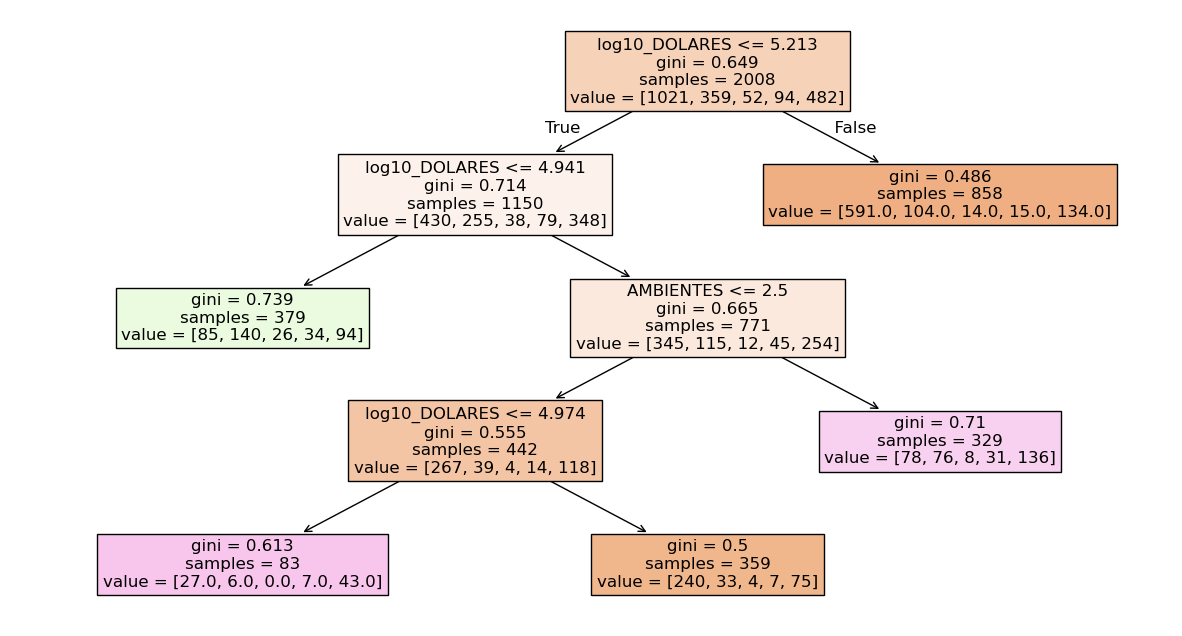

In [85]:
fig, ax = plt.subplots(figsize = (15, 8))
plot_tree(dtc, feature_names=features, fontsize = 12, filled = True, ax = ax)

In [86]:
# Fine tunning by iterating over alpha
for alpha in np.logspace(-10, 0, 11):
    dtc = DecisionTreeClassifier(ccp_alpha = alpha, random_state = random_seed)
    scores = cross_val_score(dtc, X_train_c, y_train_c, cv = 5)
    print(f'Alpha value {alpha} - CV mean score = {scores.mean()}')

Alpha value 1e-10 - CV mean score = 0.6763042642150843
Alpha value 1e-09 - CV mean score = 0.6763042642150843
Alpha value 1e-08 - CV mean score = 0.6763042642150843
Alpha value 1e-07 - CV mean score = 0.6763042642150843
Alpha value 1e-06 - CV mean score = 0.6763042642150843
Alpha value 1e-05 - CV mean score = 0.6763042642150843
Alpha value 0.0001 - CV mean score = 0.6763042642150843
Alpha value 0.001 - CV mean score = 0.6628602622796242
Alpha value 0.01 - CV mean score = 0.5528020744159502
Alpha value 0.1 - CV mean score = 0.5084663961985583
Alpha value 1.0 - CV mean score = 0.5084663961985583


In [87]:
alpha = 10**-5
dtr = DecisionTreeClassifier(ccp_alpha = alpha, random_state = random_seed)
dtr.fit(X_train_c, y_train_c)
print(f'Test score: {dtr.score(X_test_c, y_test_c)}')

Test score: 0.6919642857142857


View of the probability of the target in each X_test case.

In [88]:
pd.DataFrame(data=dtr.predict_proba(X_test_c), columns=dtr.classes_)

,A,B,C,D,E
0,1.000000,0.0,0.0,0.0,0.000000
1,1.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.0,0.0,0.0,1.000000
3,0.071429,0.0,0.0,0.0,0.928571
4,1.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...
219,1.000000,0.0,0.0,0.0,0.000000
220,0.000000,1.0,0.0,0.0,0.000000
221,1.000000,0.0,0.0,0.0,0.000000
222,0.000000,0.0,0.0,0.0,1.000000


## 2.2) Decision Tree Binary Classifier

Let's score the model using AUC.

In [89]:
zonas_A_B = {'COMUNA 01': 1, 'COMUNA 02': 0, 'COMUNA 03': 1,   # Relabels areas in binary 0 / 1 and trains the model
            'COMUNA 04': 1, 'COMUNA 05': 1, 'COMUNA 06': 1,
            'COMUNA 07': 0, 'COMUNA 08': 1, 'COMUNA 09': 1,
            'COMUNA 10': 0, 'COMUNA 11': 1, 'COMUNA 12': 1,
            'COMUNA 13': 0, 'COMUNA 14': 0, 'COMUNA 15': 1}

df['ZONA_A_B'] = df['COMUNA'].apply(lambda x: zonas_A_B[x])

features = ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'log10_DOLARES']
target = 'ZONA_A_B'

X = df[features].to_numpy()
y = df[target].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10 )
dtcb = DecisionTreeClassifier(max_leaf_nodes = 5 ) 

dtcb.fit(X_train, y_train)
train_score = dtcb.score(X_train, y_train)
test_score = dtcb.score(X_test, y_test)

print(f"{df['ZONA_A_B'].value_counts()}\n")

print(f'Train score: {train_score}')
print(f'Test score: {test_score}\n')

probas = dtcb.predict_proba(X_test) 

ZONA_A_B
1    1124
0    1108
Name: count, dtype: int64

Train score: 0.6862549800796812
Test score: 0.7008928571428571



In [90]:
# Example of Confusion Matrix, TPR and FPR with a 0.4 value of threshold
def TPR_FPR(cm): 
  TPR = cm[0,0]/(cm[0,0]+cm[0,1])
  FPR = cm[1,0]/(cm[1,0]+cm[1,1])
  return [TPR,FPR] 

T = 0.4 
ypred = np.zeros(probas.shape[0])       # Creates a 'probas''s length new 'ypred' column with zeros values
ypred[probas[:,1]>T] = 1                # In 'ypred' col puts 1 on values higher than T value
cm = confusion_matrix(y_test, ypred)
metricas = TPR_FPR(cm)

print('Confusion matrix:')
print(cm)
print(f'\nTrue positive rate: {round(metricas[0],4)}')
print(f'False positive rate: {round(metricas[1],4)}')

Confusion matrix:
[[82 35]
 [32 75]]

True positive rate: 0.7009
False positive rate: 0.2991


In [91]:
# Ratio target labels
unique, counts = np.unique(ypred, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0. 114.]
 [  1. 110.]]


[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]


Text(0, 0.5, 'True positive rate')

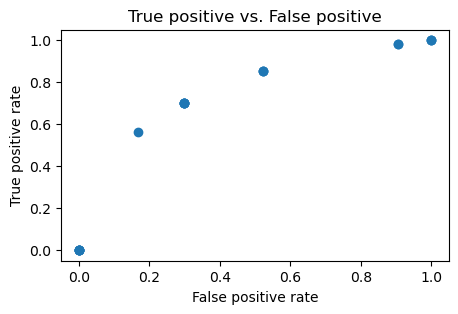

In [92]:
# Plots TPR vs FPR while changes the threshold
Ts = np.arange(0,1,0.05) 
print(Ts)
TPRs = []  
FPRs = [] 
for T in Ts:
  ypred = np.zeros(probas.shape[0]) 
  ypred[probas[:,1]>T] = 1 
  cm = confusion_matrix(y_test, ypred) 
  metricas = TPR_FPR(cm) 
  TPRs.append(metricas[0]) 
  FPRs.append(metricas[1])

fig, ax = plt.subplots(figsize = (5,3))
ax.set_title('True positive vs. False positive')
ax.scatter(FPRs,TPRs)
ax.set_xlabel('False positive rate') 
ax.set_ylabel('True positive rate')

AUC: 0.7494


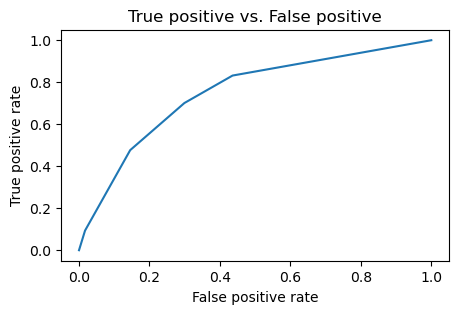

In [93]:
# Plots the ROC and calulates AUC
fpr, tpr, thresholds = roc_curve(y_test, probas[:,1]) 
fig, ax = plt.subplots(figsize = (5,3))
ax.set_title('True positive vs. False positive')
ax.plot(fpr,tpr) 
ax.set_xlabel('False positive rate') 
ax.set_ylabel('True positive rate')

auc = roc_auc_score(y_test, probas[:,1]) 

print(f'AUC: {round(auc,4)}') 

### StratifiedKFold
The feature - target data is somehow balanced. But every time we train-split, that ratio is not guaranteed to be balanced again. Let's use StratifiedKFold to compensate this. <br> It yields no significant AUC improvement.

In [94]:
skf = StratifiedKFold(n_splits=5, shuffle=True)     
skf.get_n_splits(X, y) 

auc_values = []            # Stores the auc_values of each skf.split to means AUC

for train_index, test_index in skf.split(X, y):               # Train-split by index dictated by skf.split.          
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]    

    dtcb = DecisionTreeClassifier(max_leaf_nodes = 5 )         # Create, fit and predict_probas of the model
    dtcb.fit(X_train, y_train)
    probas_test = dtcb.predict_proba(X_test) 

    auc_test = roc_auc_score(y_test, probas_test[:,1])          # Calculate auc_score

    auc_values.append(auc_test)

print(f'AUC means: {np.mean(auc_values)}')

AUC means: 0.7037714042824337


### Feature engineering
Let's try expanding the feature field by elevating the features to the power of 2, 3, 4 y 5. <br> It yields no significant AUC improvement.

In [95]:
skf = StratifiedKFold(n_splits=5, shuffle=True) 

X_cb_features_ing = np.concatenate((X, X**2,X**3,X**4, X**5), axis=1) # Elevate the features to the powers and concat.

skf.get_n_splits(X_cb_features_ing, y) 

auc_values = []     

for train_index, test_index in skf.split(X_cb_features_ing, y):                
    X_train, X_test = X_cb_features_ing[train_index], X_cb_features_ing[test_index] 
    y_train, y_test = y[train_index], y[test_index]    

    dtcb = DecisionTreeClassifier(max_leaf_nodes = 5 ) 
    dtcb.fit(X_train, y_train)
    probas_test = dtcb.predict_proba(X_test) 

    auc_test = roc_auc_score(y_test, probas_test[:,1]) 

    auc_values.append(auc_test)

print(f'AUC means: {np.mean(auc_values)}')

AUC means: 0.6995351470976471


### SelectKBest
With SelectKBest we will explore the importance of each feature per StratifiedKFold split. In this case let's see the best 3 features. <br>
It yields no significant AUC improvement.

AUC means: 0.7009743697317227


Text(0, 0.5, 'Folds')

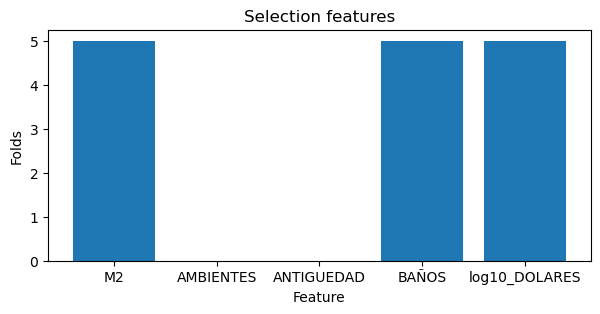

In [96]:
Kbest = 3  # Best K features it will hold

skf = StratifiedKFold(n_splits=5, shuffle=True)     
skf.get_n_splits(X, y) 
  
auc_values_fs =  []     # Stores the auc_values of each skf.split per feature selected means AUC later
selected_features= np.array([]).reshape(0,X.shape[1]) 

for train_index, test_index in skf.split(X, y): 
    X_train, X_test= X[train_index], X[test_index]
    y_train, y_test= y[train_index], y[test_index]     

    selector = SelectKBest(k=Kbest) 
    selector.fit(X_train, y_train)
    X_train_fs = selector.transform(X_train) 
    X_test_fs = selector.transform(X_test) 
    features = np.array(selector.get_support()).reshape((1,-1))
    selected_features =  np.concatenate((selected_features,features),axis=0)

    dtcb = DecisionTreeClassifier(max_leaf_nodes = 5 ) 
    dtcb.fit(X_train_fs, y_train)
    probas_test = dtcb.predict_proba(X_test_fs) 

    auc_test = roc_auc_score(y_test, probas_test[:,1]) 
    auc_values_fs.append(auc_test)

print(f'AUC means: {np.mean(auc_values_fs)}')

plt.figure(figsize=(7,3)) 
plt.bar(np.arange(0,X.shape[1]),np.sum(selected_features,axis=0))
plt.title('Selection features')
plt.xlabel('Feature')
plt.xticks(np.arange(0,X.shape[1]), ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'log10_DOLARES'])
plt.ylabel('Folds')


By setting only 1 KBest we will find the most important feature regarding the clasification model. <br>
That feature is 'log10_DOLARES' during the 5 splits and the model yields no significant AUC improvement. So this columns it's the most important for this model in order to classify.

AUC means: 0.6941744186817717


Text(0, 0.5, 'Folds')

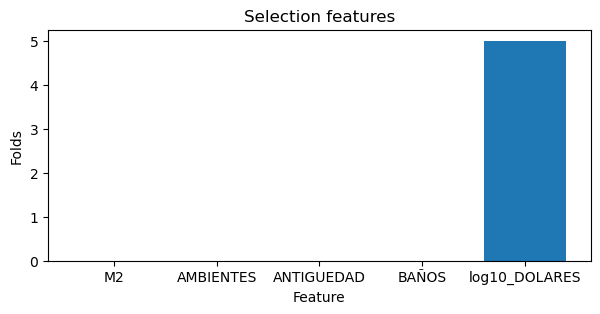

In [97]:
Kbest = 1 

skf = StratifiedKFold(n_splits=5, shuffle=True) 
skf.get_n_splits(X, y) 

auc_values = []            
probas_values = np.array([])    # Stores the predict_proba of each skf.split to ROC later 
targets = np.array([])          # Stores the y_test of each skf.split to ROC later

selected_features= np.array([]).reshape(0,X.shape[1]) 

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]    

    selector = SelectKBest(k=Kbest) 
    selector.fit(X_train, y_train) 
    X_train_fs = selector.transform(X_train) 
    X_test_fs = selector.transform(X_test) 
    features = np.array(selector.get_support()).reshape((1,-1)) 

    selected_features =  np.concatenate((selected_features,features),axis=0)
    dtcb = DecisionTreeClassifier(max_leaf_nodes = 5 ) 
    dtcb.fit(X_train_fs, y_train)
    probas_test = dtcb.predict_proba(X_test_fs) 

    auc_test = roc_auc_score(y_test, probas_test[:,1]) 

    probas_values = np.concatenate((probas_values,probas_test[:,1]),axis=0)
    auc_values.append(auc_test)
    targets = np.concatenate((targets,y_test),axis=0)

print(f'AUC means: {np.mean(auc_values)}')

plt.figure(figsize=(7,3))
plt.bar(np.arange(0,X.shape[1]),np.sum(selected_features,axis=0))
plt.title('Selection features')
plt.xlabel('Feature')
plt.xticks(np.arange(0,X.shape[1]), ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'log10_DOLARES'])
plt.ylabel('Folds')

And how do we know our model is better than chance level? We will shuffle the train data in order to break any relationship between them and the Test one. Then calculate its AUC and plot it.

In [98]:
y_shuffled = y.copy() 
shuffle(y_shuffled)

skf = StratifiedKFold(n_splits=5, shuffle=True) 
skf.get_n_splits(X, y_shuffled) 

auc_values_shuffled = [] 
probas_values_shuffled = np.array([])    
targets_shuffled = np.array([])    

for train_index, test_index in skf.split(X,y_shuffled): 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]     

    selector = SelectKBest(k=Kbest) 
    selector.fit(X_train, y_train) 
    X_train_fs = selector.transform(X_train) 
    X_test_fs = selector.transform(X_test) 
    features = np.array(selector.get_support()).reshape((1,-1))
    selected_features =  np.concatenate((selected_features,features),axis=0)

    dtcb = DecisionTreeClassifier(max_leaf_nodes = 5 ) 
    dtcb.fit(X_train_fs, y_train)
    probas_test = dtcb.predict_proba(X_test_fs) 
    
    auc_test_shuffled = roc_auc_score(y_test, probas_test[:,1]) 

    auc_values_shuffled.append(auc_test_shuffled)
    probas_values_shuffled = np.concatenate((probas_values_shuffled,probas_test[:,1]),axis=0)
    targets_shuffled = np.concatenate((targets_shuffled,y_test),axis=0)

Compared with the chance level, only the column 'log10_DOLARES' is a good classifier.

Normal AUC means: 0.6941744186817717
Shuffled AUC means: 0.49862527111791816


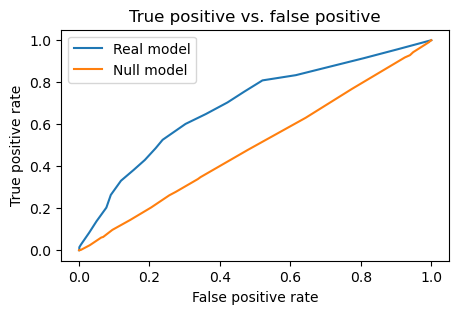

In [99]:
fpr, tpr, thresholds = roc_curve(targets, probas_values)
fpr_shuffled, tpr_shuffled, thresholds_shuffled = roc_curve(targets_shuffled, probas_values_shuffled)

print(f'Normal AUC means: {np.mean(auc_values)}')
print(f'Shuffled AUC means: {np.mean(auc_values_shuffled)}')

fig, ax = plt.subplots(figsize = (5,3))
ax.set_title('True positive vs. false positive')
ax.plot(fpr,tpr, label='Real model')
ax.plot(fpr_shuffled,tpr_shuffled, label='Null model')

ax.set_xlabel('False positive rate') 
ax.set_ylabel('True positive rate') 
plt.legend()

## 2.3) Random Forest Binary Classifier <br>
Using a plain Random Forest we get a very good AUC. Exploring a bit we expose the same feature importance as in the previous Decision Tree. While trying to use StratifiedKFold no significant AUC improvement is yielded.

In [100]:
features = ['M2', 'AMBIENTES', 'ANTIGUEDAD', 'BAÑOS', 'log10_DOLARES']
target = 'ZONA_A_B'

X = df[features].to_numpy()
y = df[target].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10 ) 

for estim in [100, 500, 1000]:
    rfcb = RandomForestClassifier(n_estimators=estim)
    rfcb.fit(X_train, y_train)
    probas_rfcb = rfcb.predict_proba(X_test)
    print(f'Accuracy score Random Forest with {estim} estimator: {round(rfcb.score(X_test, y_test), 5)}')

Accuracy score Random Forest with 100 estimator: 0.83929
Accuracy score Random Forest with 500 estimator: 0.84821
Accuracy score Random Forest with 1000 estimator: 0.85268


In [101]:
# Explores feature importance
feature_importance = rfcb.feature_importances_
pd.DataFrame(data={'feature':features, 'importance':feature_importance}).sort_values(by='importance', ascending=False).reset_index(drop=True)

,feature,importance
0,log10_DOLARES,0.407307
1,M2,0.305329
2,ANTIGUEDAD,0.190450
3,AMBIENTES,0.061418
4,BAÑOS,0.035496


AUC: 0.9217


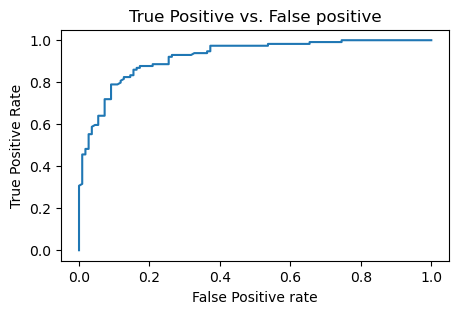

In [102]:
# Plots the ROC and calulates AUC
fpr, tpr, thresholds = roc_curve(y_test, probas_rfcb[:,1]) 

fig, ax = plt.subplots(figsize = (5,3))
ax.set_title('True Positive vs. False positive')
ax.plot(fpr,tpr) 
ax.set_xlabel('False Positive rate') 
ax.set_ylabel('True Positive Rate')

auc = roc_auc_score(y_test, probas_rfcb[:,1]) 

print(f'AUC: {format(round(auc,4))}')

In [103]:
skf = StratifiedKFold(n_splits=5, shuffle=True) 
skf.get_n_splits(X, y) 

auc_values = []          

for train_index, test_index in skf.split(X, y):                
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index] 

    rfcb = RandomForestClassifier(n_estimators=100)
    rfcb.fit(X_train, y_train) 

    probas_test = rfcb.predict_proba(X_test) 

    auc_test = roc_auc_score(y_test, probas_test[:,1]) 

    auc_values.append(auc_test)

print(f'AUC means: {np.mean(auc_values)}')

AUC means: 0.8850005147358088
